In [ ]:
!pip install unsloth transformers peft accelerate bitsandbytes python-dotenv

In [2]:
import torch
from google.colab import drive
drive.mount('/content/drive')
from unsloth import FastLanguageModel
from peft import PeftModel
from transformers import AutoTokenizer
import torch
import json
import os
import re
import json
import torch
import sqlite3
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from huggingface_hub import login
# from dotenv import load_dotenv
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
from dotenv import load_dotenv
from transformers import TextStreamer

Mounted at /content/drive
🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [115]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
print(torch.cuda.is_available(),torch.cuda.get_device_name())

True Tesla T4


---

In [ ]:
# HF token
load_dotenv(dotenv_path="./env.txt")

# HF login
login(token=os.getenv("HUGGINGFACE_TOKEN", None))

In [ ]:
class ModelLoader:
    def __init__(self, model_name, model_path):
        device = "cuda" if torch.cuda.is_available() else "cpu"
        print(f"Using device: {device}")  # Check if running on GPU or CPU
        self.tokenizer = AutoTokenizer.from_pretrained(model_path)
        self.model = AutoModelForCausalLM.from_pretrained(
            model_path,
            torch_dtype=torch.float16 if device == "cuda" else torch.float32
        ).to(device)
        self.model.eval()
        self.pipeline = pipeline(
            "text-generation",
            model=self.model,
            tokenizer=self.tokenizer,
            device=0 if device == "cuda" else -1,
            truncation=True,
            pad_token_id=self.tokenizer.eos_token_id,
            temperature=0.5,
            top_p=0.7,
            max_length=512,
            return_full_text=False
        )

In [ ]:
class SQLPromptBuilder:
    def __init__(self, base_prompt):
        self.base_prompt = base_prompt

    def build_prompt(self, question, schema):
        schema_str = "\n".join([f"{col}: {dtype}" for col, dtype in schema.items()])
        return (
            f"You are a data analyst bot working with a database. The table nba_roster has the following columns and metadata:\n\n"
            f"Team: A string containing the team name (e.g., \"Atlanta Hawks\", \"Washington Wizards\").\n"
            f"NAME: A string containing the player's name (e.g., \"Saddiq Bey\", \"Corey Kispert\").\n"
            f"Jersey: A string containing the player's jersey number (e.g., \"1\", \"55\").\n"
            f"POS: A string containing the player's position (e.g., \"SF\", \"SG\", \"G\").\n"
            f"AGE: An integer containing the player's age (e.g., 23, 31).\n"
            f"HT: A string containing the player's height in feet and inches (e.g., \"6'6\", \"6'2\").\n"
            f"WT: A string containing the player's weight in pounds (e.g., \"180 lbs\", \"185 lbs\").\n"
            f"COLLEGE: A string containing the player's college name (e.g., \"Utah\", \"Toledo\").\n"
            f"SALARY: A string containing the player's salary, formatted with a dollar sign (e.g., \"$8,195,122\", \"$1,719,864\").\n\n"
            f"You must generate a response that is ONLY a JSON object. The JSON object must have exactly two keys: \"question\" and \"sql\".\n"
            f"DO NOT include any extra text, explanations, or commentary outside the JSON object. The JSON must begin with '{{' and end with '}}' and nothing else.\n\n"
            f"The output of your response is directly fed to another system, and no human is reading it. Providing anything other than JSON will cause the other system to crash."
            f"Format your response as follows:\n"
            f"{{\n"
            f"  \"question\": \"<The given question>\",\n"
            f"  \"sql\": \"<The SQL query>\"\n"
            f"}}\n\n"
            f"Example:\n"
            f"Question: What are all the rows of the table in the database?\n"
            f"Response:\n"
            f"{{\n"
            f"  \"question\": \"What are all the rows of the table in the database?\",\n"
            f"  \"sql\": \"SELECT * FROM nba_roster;\"\n"
            f"}}\n\n"
            f"REMEMBER: DO NOT YAP. DO NOT PROVIDE ANYTHING OTHER THAN THE JSON."
            f"Now, answer the following question:\n"
            f"Question: {question}"
        )

In [ ]:
class SQLQueryGenerator:
    def __init__(self, model_loader, prompt_builder):
        self.model_loader = model_loader
        self.prompt_builder = prompt_builder

    def generate_response(self, question, schema):
        prompt = self.prompt_builder.build_prompt(question, schema)
        with torch.no_grad():
            response = self.model_loader.pipeline(prompt, num_return_sequences=1)
        raw_output = response[0]["generated_text"]
        print(raw_output)

        return self.extract_json(raw_output)

    @staticmethod
    def extract_json(output):
        try:
            start = output.index("{")
            end = output.rindex("}") + 1
            return json.loads(output[start:end])
        except (ValueError, json.JSONDecodeError):
            return {"error": "Failed to extract valid JSON"}

In [ ]:
class SQLExecutor:
    def __init__(self, db_connection):
        self.db_connection = db_connection

    def execute(self, sql):
        try:
            query_result = pd.read_sql_query(sql, self.db_connection)
            return query_result
        except Exception as e:
            return f"Error: {e}"

In [ ]:
class SQLQueryPipeline:
    def __init__(self, db_connection, base_prompt, questions_file):
        self.db_connection = db_connection
        self.models = {}
        self.prompt_builder = SQLPromptBuilder(base_prompt)
        self.questions_file = questions_file
        self.sql_executor = SQLExecutor(db_connection)

    def add_model(self, model_name, model_path):
        self.models[model_name] = ModelLoader(model_name, model_path)

    def load_questions(self):
        with open(self.questions_file, "r") as f:
            return [json.loads(line) for line in f]

    def get_schema(self):
        query = "PRAGMA table_info(nba_roster);"
        schema_info = pd.read_sql_query(query, self.db_connection)
        schema = {row["name"]: row["type"] for _, row in schema_info.iterrows()}
        return schema

    def run_pipeline(self):
        questions = self.load_questions()
        accuracy_scores = {model_name: {'syntax': 0, 'semantics': 0} for model_name in self.models}
        total_questions = len(questions)
        results = {model_name: [] for model_name in self.models}
        schema = self.get_schema() ## I DONT UNDERSTAND

        for model_name, model_loader in self.models.items():
            # Force clear the cache
            torch.cuda.empty_cache()
            generator = SQLQueryGenerator(model_loader, self.prompt_builder)
            for question_data in tqdm(questions, desc=f"Processing questions for {model_name}"):
                question = question_data["question"]
                ground_truth_sql = question_data["sql"]

                # Get the expected result
                expected_result = self.sql_executor.execute(ground_truth_sql)

                # Generate the SQL query
                response = generator.generate_response(question, schema)
                sql_query = response.get("sql", "")
                generated_result = None

                # Check for syntax correctness by attempting to execute the query
                syntax_correct = self.execute_sql_without_error(sql_query)

                if syntax_correct:
                    generated_result = self.sql_executor.execute(sql_query)

                # Compare for semantics correctness
                semantics_correct = self.compare_results(expected_result, generated_result) if syntax_correct else False

                # Update accuracy scores
                accuracy_scores[model_name]['syntax'] += int(syntax_correct)
                accuracy_scores[model_name]['semantics'] += int(semantics_correct)

                # Save the results
                results[model_name].append({
                    "question": question,
                    "generated_sql": sql_query,
                    "expected_sql": ground_truth_sql,
                    "generated_result": generated_result,
                    "expected_result": expected_result,
                    "syntax_correct": syntax_correct,
                    "semantics_correct": semantics_correct
                })

        # Calculate accuracy percentages
        accuracy_scores = {
            model: {
                'syntax': (score['syntax'] / total_questions) * 100,
                'semantics': (score['semantics'] / total_questions) * 100
            }
            for model, score in accuracy_scores.items()
        }

        # Save results to CSV files
        for model_name, result_data in results.items():
            result_df = pd.DataFrame(result_data)
            result_df.to_csv(f"{model_name}_results.csv", index=False)

        # Plot accuracy results
        self.plot_accuracy(accuracy_scores)
        return accuracy_scores

    def execute_sql_without_error(self, sql):
        try:
            # We execute the query directly on the database
            pd.read_sql_query(sql, self.db_connection)
            return True  # No error
        except Exception:
            return False  # Error executing query

    def compare_results(self, expected_result, generated_result):
        # Compare results for correctness (could be enhanced to check for specific data frame results)
        return expected_result.equals(generated_result)

    def plot_accuracy(self, accuracy_scores):
        fig, ax = plt.subplots(figsize=(10, 6))

        # Plotting the syntax and semantics accuracy
        models = list(accuracy_scores.keys())
        syntax_accuracies = [score['syntax'] for score in accuracy_scores.values()]
        semantics_accuracies = [score['semantics'] for score in accuracy_scores.values()]

        bar_width = 0.35
        index = range(len(models))

        ax.bar(index, syntax_accuracies, bar_width, label='Syntax Accuracy', color='blue')
        ax.bar([i + bar_width for i in index], semantics_accuracies, bar_width, label='Semantics Accuracy', color='green')

        ax.set_xlabel('Models')
        ax.set_ylabel('Accuracy (%)')
        ax.set_title('SQL Query Accuracy by Syntax and Semantics Across Models')
        ax.set_xticks([i + bar_width / 2 for i in index])
        ax.set_xticklabels(models)
        ax.legend()

        plt.tight_layout()
        plt.show()

In [ ]:
database_path = os.path.join(os.getcwd(), 'nba_roster_super_cleaned.db') ## I DONT UNDERSTAND
db_connection = sqlite3.connect(database_path)

In [ ]:
base_prompt = "You are a data analyst working with a database."
questions_file = os.path.join(os.getcwd(), 'gold-test-set-v2.jsonl') ## I DONT UNDERSTAND

In [ ]:
pipeline_obj = SQLQueryPipeline(db_connection, base_prompt, questions_file)

In [ ]:
pipeline_obj.add_model("llama 3.2 1B-instruct", "meta-llama/Llama-3.2-1B-instruct")

Using device: cuda


Device set to use cuda:0


In [ ]:
# pipeline_obj.add_model("llama 3.2 3B-instruct", "meta-llama/Llama-3.2-3B-instruct")

In [ ]:
# accuracy_scores = pipeline_obj.run_pipeline()
# print("Model Accuracy Scores:", accuracy_scores)

In [ ]:
pipeline_obj.add_model("llama 3.2 3B-instruct", "meta-llama/Llama-3.2-3B-instruct")

Using device: cuda


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cuda:0


Processing questions for llama 3.2 1B-instruct:   2%|▎         | 1/40 [00:00<00:38,  1.02it/s]

 
Response:
{
  "question": "Who is the pointguard for the Golden State Warriors?",
  "sql": "SELECT NAME, COLLEGE, HT, WT, AGE, SALARY FROM nba_roster WHERE POS = 'PG'"
}


Processing questions for llama 3.2 1B-instruct:   5%|▌         | 2/40 [00:01<00:33,  1.15it/s]

?
Response:
{
  "question": "What is the number of players on the Chicago Bulls who are 25 years old or younger?",
  "sql": "SELECT COUNT(*) FROM nba_roster WHERE AGE < 25 AND TEAM = 'Chicago Bulls';"
}


Processing questions for llama 3.2 1B-instruct:   8%|▊         | 3/40 [00:02<00:30,  1.21it/s]

?
Response:
{
  "question": "Who is the highest-paid player on the Los Angeles Lakers?",
  "sql": "SELECT * FROM nba_roster WHERE TEAM = 'Los Angeles Lakers' AND SALARY = '$1,719,864'"
}


Processing questions for llama 3.2 1B-instruct:  10%|█         | 4/40 [00:03<00:27,  1.30it/s]

 
Response:
{
  "question": "Who is the highest paid player in the NBA?",
  "sql": "SELECT * FROM nba_roster WHERE SALARY = (SELECT MAX(SALARY) FROM nba_roster)"
}


Processing questions for llama 3.2 1B-instruct:  12%|█▎        | 5/40 [00:04<00:28,  1.23it/s]

Question: LaMelo Ball is on the Charlotte HornetsQuestion: What is LaMelo Ball's jersey number?Question: LaMelo Ball's jersey number is 2Question: What is LaMelo Ball's position?Question: LaMelo Ball's position is point guardQuestion: What is LaMelo Ball's


Processing questions for llama 3.2 1B-instruct:  15%|█▌        | 6/40 [00:04<00:24,  1.36it/s]

 
Response:
{
  "question": "How much does Lonzo Ball weigh?",
  "sql": "SELECT WT FROM nba_roster WHERE NAME = 'Lonzo Ball';" }



Processing questions for llama 3.2 1B-instruct:  20%|██        | 8/40 [00:05<00:16,  1.89it/s]

 
Response:
{
  "question": "How old is Lebron James?",
  "sql": "SELECT AGE FROM nba_roster WHERE NAME = 'Lebron James';"
}


Processing questions for llama 3.2 1B-instruct:  22%|██▎       | 9/40 [00:06<00:18,  1.65it/s]

 
Response:
{
  "question": "What is the most popular jersey number in the current NBA?",
  "sql": "SELECT jersey FROM nba_roster WHERE jersey = (SELECT MAX(jersey) FROM nba_roster) ORDER BY COUNT(*) DESC LIMIT 1;"
}


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


 
Response:
{
  "question": "Can you give me a list of all the players without college data?",
  "sql": "SELECT * FROM nba_roster WHERE COLLEGE IS NULL;"
}


Processing questions for llama 3.2 1B-instruct:  28%|██▊       | 11/40 [00:07<00:17,  1.68it/s]

 
Response:
{
  "question": "What team has the smallest roster?",
  "sql": "SELECT Team FROM nba_roster ORDER BY COUNT(*) ASC LIMIT 1;"}


Processing questions for llama 3.2 1B-instruct:  30%|███       | 12/40 [00:08<00:19,  1.44it/s]

 (i.e., the team with the most players)
Response:
{
  "question": "What team has the largest roster? (i.e., the team with the most players)",
  "sql": "SELECT Team, COUNT(*) FROM nba_roster GROUP BY Team ORDER BY COUNT(*) DESC LIMIT 1;"}


Processing questions for llama 3.2 1B-instruct:  32%|███▎      | 13/40 [00:09<00:19,  1.38it/s]

 

Response:
{
  "question": "What team is paying its players the most in total?",
  "sql": "SELECT Team, SUM(SALARY) FROM nba_roster GROUP BY Team ORDER BY SUM(SALARY) DESC LIMIT 1;"
}


Processing questions for llama 3.2 1B-instruct:  35%|███▌      | 14/40 [00:09<00:18,  1.38it/s]

 

Response:
{
  "question": "Which team is paying its players the least?",
  "sql": "SELECT Team, SALARY FROM nba_roster GROUP BY Team ORDER BY SUM(SALARY) ASC LIMIT 1;"}


Processing questions for llama 3.2 1B-instruct:  38%|███▊      | 15/40 [00:10<00:19,  1.29it/s]

 The team with the highest average height is which team?
Response:
{
  "question": "Which team is on average the tallest? The team with the highest average height is which team?",
  "sql": "SELECT AVG(HT) FROM nba_roster GROUP BY TEAM ORDER BY AVG(HT) DESC LIMIT 1;"


Processing questions for llama 3.2 1B-instruct:  40%|████      | 16/40 [00:11<00:17,  1.40it/s]

 

Response:
{
  "question": "Which team is on average the shortest?",
  "sql": "SELECT AVG(HT) FROM nba_roster WHERE POS = 'SF'"
}


Processing questions for llama 3.2 1B-instruct:  42%|████▎     | 17/40 [00:11<00:15,  1.48it/s]

 

Response:
{
  "question": "Who are the tallest 5 centers in the league?",
  "sql": "SELECT * FROM nba_roster WHERE POS = 'C'"
}


Processing questions for llama 3.2 1B-instruct:  45%|████▌     | 18/40 [00:12<00:15,  1.42it/s]

 
Response:
{
  "question": "Who are the top 5 highest paid power forwards in the league?",
  "sql": "SELECT NAME, SALARY FROM nba_roster WHERE POS = 'PF' ORDER BY SALARY DESC LIMIT 5;"
}


Processing questions for llama 3.2 1B-instruct:  48%|████▊     | 19/40 [00:13<00:13,  1.53it/s]

 
Response:
{
  "question": "What is the median salary in the NBA?",
  "sql": "SELECT AVG(SALARY) FROM nba_roster;"
}


Processing questions for llama 3.2 1B-instruct:  50%|█████     | 20/40 [00:13<00:12,  1.62it/s]

 
Response:
{
  "question": "What is the average salary in the NBA?",
  "sql": "SELECT AVG(SALARY) FROM nba_roster;"
}


Processing questions for llama 3.2 1B-instruct:  52%|█████▎    | 21/40 [00:14<00:11,  1.60it/s]

 
Response:
{
  "question": "What is the 99th percentile salary in the NBA?",
  "sql": "SELECT SALARY FROM nba_roster ORDER BY SALARY DESC LIMIT 99;"}


Processing questions for llama 3.2 1B-instruct:  55%|█████▌    | 22/40 [00:15<00:12,  1.48it/s]

 
Response:
{
  "question": "What is the 75th percentile salary in the NBA?",
  "sql": "SELECT AVG(SALARY) FROM nba_roster WHERE SALARY > (SELECT AVG(SALARY) FROM nba_roster)"
}


Processing questions for llama 3.2 1B-instruct:  57%|█████▊    | 23/40 [00:15<00:11,  1.50it/s]

 Response:
{
  "question": "What is the 25th percentile salary in the NBA?",
  "sql": "SELECT AVG(SALARY) FROM nba_roster ORDER BY SALARY DESC LIMIT 1;"}


Processing questions for llama 3.2 1B-instruct:  60%|██████    | 24/40 [00:16<00:09,  1.61it/s]

 
Response:
{
  "question": "What is the median weight in the NBA?",
  "sql": "SELECT AVG(WT) FROM nba_roster;"
}


Processing questions for llama 3.2 1B-instruct:  62%|██████▎   | 25/40 [00:16<00:08,  1.76it/s]

 
Response:
{
  "question": "What is the average weight in the NBA?",
  "sql": "AVG(WT) OVER ()"
}


Processing questions for llama 3.2 1B-instruct:  65%|██████▌   | 26/40 [00:17<00:07,  1.82it/s]

 
Response:
{
  "question": "What is the median height in the NBA?",
  "sql": "SELECT AVG(HT) FROM nba_roster;"
}


Processing questions for llama 3.2 1B-instruct:  68%|██████▊   | 27/40 [00:17<00:06,  1.93it/s]

 
Response:
{
  "question": "What is the average height in the NBA?",
  "sql": "AVG(HT) OVER ()"
}


Processing questions for llama 3.2 1B-instruct:  70%|███████   | 28/40 [00:18<00:06,  1.87it/s]

 
Response:
{
  "question": "Can you tell me how many players are in the NBA?",
  "sql": "SELECT COUNT(*) FROM nba_roster;"
}


Processing questions for llama 3.2 1B-instruct:  72%|███████▎  | 29/40 [00:18<00:05,  2.05it/s]

 

SQL: SELECT * FROM nba_roster WHERE POS = 'SF' ORDER BY SALARY DESC LIMIT 10;


Processing questions for llama 3.2 1B-instruct:  75%|███████▌  | 30/40 [00:19<00:05,  1.95it/s]

 
Response:
{
  "question": "Is Jalen Johnson 23 years old?",
  "sql": "SELECT AGE FROM nba_roster WHERE NAME = 'Jalen Johnson';"
}


Processing questions for llama 3.2 1B-instruct:  78%|███████▊  | 31/40 [00:19<00:05,  1.74it/s]

 
Response:
{
  "question": "Who is the oldest player on the Brooklyn Nets?",
  "sql": "SELECT NAME, AGE FROM nba_roster WHERE TEAM = 'Brooklyn Nets' ORDER BY AGE DESC LIMIT 1;"
}


Processing questions for llama 3.2 1B-instruct:  80%|████████  | 32/40 [00:20<00:04,  1.70it/s]

 

Response:
{
  "question": "Who has the highest salary on the Memphis Grizzlies?",
  "sql": "SELECT * FROM nba_roster WHERE team = 'Memphis Grizzlies';" }


Processing questions for llama 3.2 1B-instruct:  82%|████████▎ | 33/40 [00:21<00:04,  1.50it/s]

 

Response:
{
  "question": "Which player has the highest salary on the Cleveland Cavaliers?",
  "sql": "SELECT * FROM nba_roster WHERE Team = 'Cleveland Cavaliers' AND SALARY = (SELECT MAX(SALARY) FROM nba_roster WHERE Team = 'Cleveland Cavaliers


Processing questions for llama 3.2 1B-instruct:  85%|████████▌ | 34/40 [00:22<00:04,  1.44it/s]

 

Response:
{
  "question": "Who is the highest paid center on the Dallas Mavericks?",
  "sql": "SELECT * FROM nba_roster WHERE COLLEGE = 'Dallas Mavericks' AND SALARY = '$1,719,864'"
}


Processing questions for llama 3.2 1B-instruct:  88%|████████▊ | 35/40 [00:22<00:03,  1.51it/s]

 
Response:
{
  "question": "How much is Marcus Smart getting paid?",
  "sql": "SELECT SALARY FROM nba_roster WHERE NAME = 'Marcus Smart';" }


Processing questions for llama 3.2 1B-instruct:  90%|█████████ | 36/40 [00:23<00:02,  1.54it/s]

 
Response:
{
  "question": "What's the average age of the Trail Blazers?",
  "sql": "SELECT AVG(AGE) FROM nba_roster WHERE TEAM = 'Trail Blazers';"
}


Processing questions for llama 3.2 1B-instruct:  92%|█████████▎| 37/40 [00:23<00:01,  1.64it/s]

 
Response:
{
  "question": "What's the median age of the NBA?",
  "sql": "SELECT AVG(AGE) FROM nba_roster;"
}


Processing questions for llama 3.2 1B-instruct:  95%|█████████▌| 38/40 [00:24<00:01,  1.63it/s]

 
Response:
{
  "question": "What's the median age of the Miami Heat?",
  "sql": "SELECT AVG(AGE) FROM nba_roster WHERE TEAM = 'Miami Heat';"
}


Processing questions for llama 3.2 1B-instruct:  98%|█████████▊| 39/40 [00:25<00:00,  1.51it/s]

?
Response:
{
  "question": "What are the 5 teams with the oldest average age in the NBA?",
  "sql": "SELECT AVG(AGE) AS avg_age FROM nba_roster GROUP BY TEAM ORDER BY avg_age DESC LIMIT 5;"}


Processing questions for llama 3.2 1B-instruct: 100%|██████████| 40/40 [00:25<00:00,  1.54it/s]


?
Response:
{
  "question": "What is the average salary of Power Forward players in the NBA?",
  "sql": "SELECT AVG(SALARY) FROM nba_roster WHERE POS = 'PF'"
}


Processing questions for llama 3.2 3B-instruct:   2%|▎         | 1/40 [00:01<00:43,  1.11s/it]

 
{
  "question": "Who is the pointguard for the Golden State Warriors?",
  "sql": "SELECT NAME FROM nba_roster WHERE TEAM = 'Golden State Warriors' AND POS = 'PG';" }


Processing questions for llama 3.2 3B-instruct:   5%|▌         | 2/40 [00:02<00:46,  1.21s/it]

?
Response:
{
  "question": "What is the number of players on the Chicago Bulls who are 25 years old or younger?",
  "sql": "SELECT COUNT(*) FROM nba_roster WHERE Team = 'Chicago Bulls' AND AGE < 25;"
}


Processing questions for llama 3.2 3B-instruct:   8%|▊         | 3/40 [00:03<00:44,  1.21s/it]

?
{
  "question": "Who is the highest-paid player on the Los Angeles Lakers?",
  "sql": "SELECT NAME, SALARY FROM nba_roster WHERE TEAM = 'Los Angeles Lakers' ORDER BY SALARY DESC LIMIT 1;" }


Processing questions for llama 3.2 3B-instruct:  10%|█         | 4/40 [00:04<00:38,  1.07s/it]

 
{
  "question": "Who is the highest paid player in the NBA?",
  "sql": "SELECT MAX(SALARY) FROM nba_roster;"
}


Processing questions for llama 3.2 3B-instruct:  12%|█▎        | 5/40 [00:05<00:35,  1.02s/it]

 
{
  "question": "What team is LaMelo Ball on?",
  "sql": "SELECT Team FROM nba_roster WHERE NAME = 'LaMelo Ball';" }


Processing questions for llama 3.2 3B-instruct:  15%|█▌        | 6/40 [00:06<00:34,  1.00s/it]

 
Response:
{
  "question": "How much does Lonzo Ball weigh?",
  "sql": "SELECT WT FROM nba_roster WHERE NAME = 'Lonzo Ball';"
}


Processing questions for llama 3.2 3B-instruct:  18%|█▊        | 7/40 [00:07<00:37,  1.13s/it]

 (Return all players and their corresponding college)
Response:
{
  "question": "What college sent the most players to the current NBA? (Return all players and their corresponding college)",
  "sql": "SELECT NAME, COLLEGE FROM nba_roster GROUP BY COLLEGE ORDER BY COUNT(NAME) DESC


Processing questions for llama 3.2 3B-instruct:  20%|██        | 8/40 [00:08<00:33,  1.05s/it]

 
{
  "question": "How old is Lebron James?",
  "sql": "SELECT AGE FROM nba_roster WHERE NAME = 'Lebron James';" }


Processing questions for llama 3.2 3B-instruct:  22%|██▎       | 9/40 [00:10<00:36,  1.16s/it]

 
{
  "question": "What is the most popular jersey number in the current NBA?",
  "sql": "SELECT Jersey FROM nba_roster GROUP BY Jersey ORDER BY COUNT(*) DESC LIMIT 1;" } 
{ 
  "question": "What is the most popular jersey number in the current NBA


Processing questions for llama 3.2 3B-instruct:  25%|██▌       | 10/40 [00:11<00:33,  1.11s/it]

 
Response:
{
  "question": "Can you give me a list of all the players without college data?",
  "sql": "SELECT * FROM nba_roster WHERE COLLEGE IS NULL;"
}


Processing questions for llama 3.2 3B-instruct:  28%|██▊       | 11/40 [00:12<00:31,  1.08s/it]

 
Response:
{
  "question": "What team has the smallest roster?",
  "sql": "SELECT Team, COUNT(*) as num FROM nba_roster GROUP BY Team ORDER BY num LIMIT 1;"
}


Processing questions for llama 3.2 3B-instruct:  30%|███       | 12/40 [00:13<00:30,  1.10s/it]

 
Response:
{
  "question": "What team has the largest roster?",
  "sql": "SELECT Team, COUNT(*) as total_players FROM nba_roster GROUP BY Team ORDER BY total_players DESC LIMIT 1;"
}


Processing questions for llama 3.2 3B-instruct:  32%|███▎      | 13/40 [00:14<00:32,  1.20s/it]

 
To calculate this, I want to calculate the total salary for each team and then find the team with the highest total salary. 

Response:
{
  "question": "What team is paying its players the most in total? ",
  "sql": "SELECT Team, SUM(SALARY) AS total_salary FROM


Processing questions for llama 3.2 3B-instruct:  35%|███▌      | 14/40 [00:16<00:33,  1.29s/it]

 
{
  "question": "Which team is paying its players the least?",
  "sql": "SELECT TEAM FROM nba_roster ORDER BY SALARY LIMIT 1;" }{ 
  "question": "Which team is paying its players the least?",
  "sql": "SELECT TEAM FROM nba_roster ORDER


Processing questions for llama 3.2 3B-instruct:  38%|███▊      | 15/40 [00:17<00:33,  1.34s/it]

 
To answer this question, I will need to:
1. Group the players by team.
2. Calculate the average height for each team.
3. Find the team with the highest average height.

Here is the SQL query to achieve this:
```sql
SELECT Team, AVG(T2.HT) AS avg_height
FROM n


Processing questions for llama 3.2 3B-instruct:  40%|████      | 16/40 [00:19<00:33,  1.38s/it]

 
To answer this question, I need to find the team with the lowest average height of its players. 

{
  "question": "Which team is on average the shortest?",
  "sql": "SELECT T1.Team, AVG(T2.HT) AS avg_height FROM nba_roster T1 LEFT JOIN (SELECT Team


Processing questions for llama 3.2 3B-instruct:  42%|████▎     | 17/40 [00:20<00:31,  1.39s/it]

 
{
  "question": "Who are the tallest 5 centers in the league?",
  "sql": "SELECT NAME, HT FROM nba_roster WHERE POS = 'C' ORDER BY CAST(REPLACE(SUBSTR(HT, INSTR(HT, \'\''), 1), \'\'', '')


Processing questions for llama 3.2 3B-instruct:  45%|████▌     | 18/40 [00:21<00:30,  1.38s/it]

 
{
  "question": "Who are the top 5 highest paid power forwards in the league?",
  "sql": "SELECT NAME, SALARY FROM nba_roster WHERE POS = 'PF' ORDER BY SALARY DESC LIMIT 5;" }{ "question": "Who are the top


Processing questions for llama 3.2 3B-instruct:  48%|████▊     | 19/40 [00:23<00:29,  1.40s/it]

 
To answer this question, I need to calculate the salary of each player and then find the median of those salaries. 

{
  "question": "What is the median salary in the NBA?",
  "sql": "SELECT SALARY FROM nba_roster; WITH median AS (SELECT AVG(SALARY) FROM n


Processing questions for llama 3.2 3B-instruct:  50%|█████     | 20/40 [00:24<00:28,  1.42s/it]

 
To calculate this, I need to know the total salary of all players and the total number of players. I need to group the SALARY column by the TEAM column, and then calculate the average salary for each team. To do this, I need to use a SQL query that groups the rows by the TEAM column, calculates


Processing questions for llama 3.2 3B-instruct:  52%|█████▎    | 21/40 [00:26<00:26,  1.42s/it]

 
{
  "question": "What is the 99th percentile salary in the NBA?",
  "sql": "SELECT SALARY FROM nba_roster ORDER BY SALARY DESC LIMIT 1;" } 
Note: The 99th percentile is the salary value below which 99% of the data points


Processing questions for llama 3.2 3B-instruct:  55%|█████▌    | 22/40 [00:27<00:25,  1.43s/it]

 
{
  "question": "What is the 75th percentile salary in the NBA?",
  "sql": "SELECT SALARY FROM nba_roster ORDER BY SALARY DESC LIMIT 1;" } 
Note: The 75th percentile salary is the salary at or above which 75% of the


Processing questions for llama 3.2 3B-instruct:  57%|█████▊    | 23/40 [00:28<00:24,  1.42s/it]

 
{
  "question": "What is the 25th percentile salary in the NBA?",
  "sql": "SELECT SALARY FROM nba_roster ORDER BY SALARY LIMIT 1 OFFSET 24;" }Note: The LIMIT 1 OFFSET 24 clause is used to find the 25th percentile


Processing questions for llama 3.2 3B-instruct:  60%|██████    | 24/40 [00:30<00:22,  1.43s/it]

 
To calculate the median weight, I need to know the weight of each player in the NBA roster. I need to convert the weight string to a numeric value first. 

{
  "question": "What is the median weight in the NBA?",
  "sql": "SELECT CAST(REPLACE(trim(WT,'lbs'),


Processing questions for llama 3.2 3B-instruct:  62%|██████▎   | 25/40 [00:31<00:21,  1.45s/it]

 
To calculate the average weight, I need to first calculate the sum of all the weights and then divide by the number of rows in the table. Since I need to calculate the average, I will use the AVG() function in SQL. Here's the SQL query to calculate the average weight:
SELECT AVG(WT) FROM n


Processing questions for llama 3.2 3B-instruct:  65%|██████▌   | 26/40 [00:33<00:20,  1.46s/it]

 
{
  "question": "What is the median height in the NBA?",
  "sql": "SELECT AVG(STRFTIME('%I', SUBSTR(HT, 2))) AS median_height FROM nba_roster GROUP BY POS ORDER BY median_height DESC LIMIT 1;" } 
Note: The STRFTIME


Processing questions for llama 3.2 3B-instruct:  68%|██████▊   | 27/40 [00:34<00:19,  1.48s/it]

 
{
  "question": "What is the average height in the NBA?",
  "sql": "SELECT AVG(T2.HT) FROM nba_roster AS T1 INNER JOIN (SELECT HT FROM nba_roster) AS T2;"
} 
However, this query does not work. The correct query should be


Processing questions for llama 3.2 3B-instruct:  70%|███████   | 28/40 [00:35<00:15,  1.32s/it]

 
Response:
{
  "question": "Can you tell me how many rows are in the table nba_roster?",
  "sql": "SELECT COUNT(*) FROM nba_roster;"
}


Processing questions for llama 3.2 3B-instruct:  72%|███████▎  | 29/40 [00:37<00:14,  1.31s/it]

 
Response:
{
  "question": "Would you please let me know what the highest paid players are for each position?",
  "sql": "SELECT NAME, POS, SALARY FROM nba_roster GROUP BY POS ORDER BY MAX(SALARY) LIMIT 1;"
}


Processing questions for llama 3.2 3B-instruct:  75%|███████▌  | 30/40 [00:38<00:11,  1.20s/it]

 
Response:
{
  "question": "Is Jalen Johnson 23 years old?",
  "sql": "SELECT AGE FROM nba_roster WHERE NAME = 'Jalen Johnson';"
}


Processing questions for llama 3.2 3B-instruct:  78%|███████▊  | 31/40 [00:39<00:11,  1.27s/it]

 
{
  "question": "Who is the oldest player on the Brooklyn Nets?",
  "sql": "SELECT MAX(AGE) FROM nba_roster WHERE Team = 'Brooklyn Nets';" } 
{ 
  "question": "Who is the oldest player on the Brooklyn Nets?",
  "sql": "


Processing questions for llama 3.2 3B-instruct:  80%|████████  | 32/40 [00:40<00:10,  1.31s/it]

 
{
  "question": "Who has the higest salary on the Memphis Grizzlies?", 
  "sql": "SELECT MAX(SALARY) FROM nba_roster WHERE Team = 'Memphis Grizzlies';" } 
{ 
  "question": "Who has the highest salary on the Memphis


Processing questions for llama 3.2 3B-instruct:  82%|████████▎ | 33/40 [00:42<00:08,  1.27s/it]

 
{
  "question": "Which player has the highest salary on the Cleveland Cavaliers?",
  "sql": "SELECT NAME, SALARY FROM nba_roster WHERE Team = 'Cleveland Cavaliers' ORDER BY SALARY DESC LIMIT 1;" }


Processing questions for llama 3.2 3B-instruct:  85%|████████▌ | 34/40 [00:43<00:07,  1.32s/it]

 
{
  "question": "Who is the highest paid center on the Dallas Mavericks?", 
  "sql": "SELECT NAME FROM nba_roster WHERE COLLEGE = 'UCLA' AND TEAM = 'Dallas Mavericks' ORDER BY SALARY DESC LIMIT 1;" } 
{ "question": "Who


Processing questions for llama 3.2 3B-instruct:  88%|████████▊ | 35/40 [00:45<00:06,  1.36s/it]

 
To: The player's name is "Marcus Smart", so we need to find the salary of the player with the name "Marcus Smart".
We can do this by using the NAME column to filter the rows in the table.

{
  "question": "How much is Marcus Smart getting paid? ",
  "sql": "SELECT


Processing questions for llama 3.2 3B-instruct:  90%|█████████ | 36/40 [00:46<00:05,  1.43s/it]

 
{
  "question": "What's the average age of the Trail Blazers?",
  "sql": "SELECT AVG(AGE) FROM nba_roster WHERE Team = 'Trail Blazers';" } 
Note: The Team column contains the team name, not the team abbreviation. 
{ 
  "question": "


Processing questions for llama 3.2 3B-instruct:  92%|█████████▎| 37/40 [00:47<00:03,  1.28s/it]

 
{
  "question": "What's the median age of the NBA?",
  "sql": "SELECT AVG(AGE) FROM nba_roster;"
}


Processing questions for llama 3.2 3B-instruct:  95%|█████████▌| 38/40 [00:48<00:02,  1.27s/it]

 team_name = "Miami Heat"
Response:
{
  "question": "What's the median age of the Miami Heat?",
  "sql": "SELECT AVG(AGE) FROM nba_roster WHERE Team = 'Miami Heat';" }


Processing questions for llama 3.2 3B-instruct:  98%|█████████▊| 39/40 [00:50<00:01,  1.30s/it]

?
{
  "question": "What are the 5 teams with the oldest average age in the NBA?",
  "sql": "SELECT Team, AVG(AGE) AS avg_age FROM nba_roster GROUP BY Team ORDER BY avg_age DESC LIMIT 5;" }{ "question": "What


Processing questions for llama 3.2 3B-instruct: 100%|██████████| 40/40 [00:51<00:00,  1.28s/it]

?
{
  "question": "What is the average salary of Power Forward players in the NBA?",
  "sql": "SELECT AVG(SALARY) FROM nba_roster WHERE POS = 'PF';" }


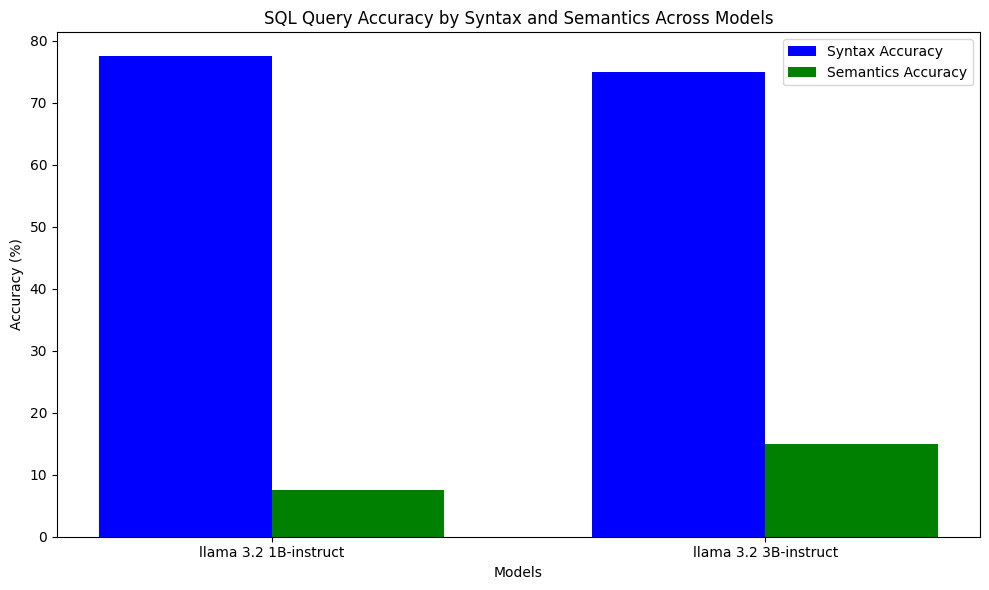

Model Accuracy Scores: {'llama 3.2 1B-instruct': {'syntax': 77.5, 'semantics': 7.5}, 'llama 3.2 3B-instruct': {'syntax': 75.0, 'semantics': 15.0}}


In [ ]:
accuracy_scores = pipeline_obj.run_pipeline()
print("Model Accuracy Scores:", accuracy_scores)

##Benchmarking Fine-tuned model

In [13]:
base_model_name = "unsloth/Llama-3.2-3B-Instruct"
adapter_path = "/content/drive/MyDrive/Capstone Project Model Weights/Model weights that work/best_model_r8_alpha8"  # Replace with your path
max_seq_length = 2048

In [14]:
# Load base model
base_model, _ = FastLanguageModel.from_pretrained(
    model_name=base_model_name,
    max_seq_length=max_seq_length,
    load_in_4bit=True,
)

# Load trained adapter
model = PeftModel.from_pretrained(base_model, adapter_path)

# Load tokenizer from saved directory
tokenizer = AutoTokenizer.from_pretrained(adapter_path)

==((====))==  Unsloth 2025.3.9: Fast Llama patching. Transformers: 4.48.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


In [17]:
question = "What is the average age of all players in the NBA"
prompt_template = """
    You are a data analyst bot working with a database. The table nba_roster has the following columns and metadata:

    Team: A string containing the team name (e.g., "Atlanta Hawks", "Washington Wizards").
    NAME: A string containing the player's name (e.g., "Saddiq Bey", "Corey Kispert").
    Jersey: A string containing the player's jersey number (e.g., "1", "55").
    POS: A string containing the player's position (e.g., "SF", "SG", "G").
    AGE: An integer containing the player's age (e.g., 23, 31).
    HT: A string containing the player's height in feet and inches (e.g., "6'6", "6'2").
    WT: A string containing the player's weight in pounds (e.g., "180 lbs", "185 lbs").
    COLLEGE: A string containing the player's college name (e.g., "Utah", "Toledo").
    SALARY: A string containing the player's salary, formatted with a dollar sign (e.g., "$8,195,122", "$1,719,864").

    You must generate a response that is ONLY a JSON object. The JSON object must have exactly two keys: "question" and "sql".
    DO NOT include any extra text, explanations, or commentary outside the JSON object. The JSON must begin with '{{' and end with '}}' and nothing else.

    The output of your response is directly fed to another system, and no human is reading it. Providing anything other than JSON will cause the other system to crash.
    Format your response as follows:
    {{
      "question": "<The given question>",
      "sql": "<The SQL query>"
    }}

    Example:
    Question: What are all the rows of the table in the database?
    Response:
    {{
      "question": "What are all the rows of the table in the database?",
      "sql": "SELECT * FROM nba_roster;"
    }}

    REMEMBER: DO NOT YAP. DO NOT PROVIDE ANYTHING OTHER THAN THE JSON.
    Now, answer the following question:
    Question: What is the average age of all players in the NBA
    SQL:
    """
FastLanguageModel.for_inference(model) # Enable native 2x faster inference
formatted_prompt = prompt_template.format(question) + tokenizer.eos_token
inputs = tokenizer(
        formatted_prompt,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=max_seq_length,
    ).to("cuda")
text_streamer = TextStreamer(tokenizer)
response = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 64)

<|begin_of_text|>
    You are a data analyst bot working with a database. The table nba_roster has the following columns and metadata:

    Team: A string containing the team name (e.g., "Atlanta Hawks", "Washington Wizards").
    NAME: A string containing the player's name (e.g., "Saddiq Bey", "Corey Kispert").
    Jersey: A string containing the player's jersey number (e.g., "1", "55").
    POS: A string containing the player's position (e.g., "SF", "SG", "G").
    AGE: An integer containing the player's age (e.g., 23, 31).
    HT: A string containing the player's height in feet and inches (e.g., "6'6", "6'2").
    WT: A string containing the player's weight in pounds (e.g., "180 lbs", "185 lbs").
    COLLEGE: A string containing the player's college name (e.g., "Utah", "Toledo").
    SALARY: A string containing the player's salary, formatted with a dollar sign (e.g., "$8,195,122", "$1,719,864").

    You must generate a response that is ONLY a JSON object. The JSON object must have 

In [124]:
#question = "What is the average age of all players in the NBA"
#question = "What are all the rows of the table in the database?"

questions = ["What is the average age of all players in the NBA","What are all the rows of the table in the database?","How old is LeBron James?","What are the names of all players on the Atlanta Hawks?","What's the average age of the Trail Blazers?"]
#questions = ["How old is Lebron James?"]

prompt_template = """
    You are a data analyst bot working with a database. The table nba_roster has the following columns and metadata:

    Team: A string containing the team name (e.g., "Atlanta Hawks", "Washington Wizards").
    NAME: A string containing the player's name (e.g., "Saddiq Bey", "Corey Kispert").
    Jersey: A string containing the player's jersey number (e.g., "1", "55").
    POS: A string containing the player's position (e.g., "SF", "SG", "G").
    AGE: An integer containing the player's age (e.g., 23, 31).
    HT: A string containing the player's height in feet and inches (e.g., "6'6", "6'2").
    WT: A string containing the player's weight in pounds (e.g., "180 lbs", "185 lbs").
    COLLEGE: A string containing the player's college name (e.g., "Utah", "Toledo").
    SALARY: A string containing the player's salary, formatted with a dollar sign (e.g., "$8,195,122", "$1,719,864").

    You must generate a response that is ONLY a JSON object. The JSON object must have exactly two keys: "question" and "sql".
    DO NOT include any extra text, explanations, or commentary outside the JSON object. The JSON must begin with '{{' and end with '}}' and nothing else.

    The output of your response is directly fed to another system, and no human is reading it. Providing anything other than JSON will cause the other system to crash.
    Format your response as follows:
    {{
      "question": "<The given question>",
      "sql": "<The SQL query>"
    }}

    Example:
    Question: What are all the rows of the table in the database?
    Response:
    {{
      "question": "What are all the rows of the table in the database?",
      "sql": "SELECT * FROM nba_roster;"
    }}

    REMEMBER: DO NOT YAP. DO NOT PROVIDE ANYTHING OTHER THAN THE JSON.
    In case of names like team name or Player name please use the exact case. If player name is aKsHAY then exactly use name = 'aKsHAY'
    Now, answer the following question:
    Question: {}
    SQL:
    """
  # Enable native 2x faster inference
for question in questions:
  formatted_prompt = prompt_template.format(question) + tokenizer.eos_token
  inputs = tokenizer(
      formatted_prompt,
      return_tensors="pt",
      padding=True,
      truncation=True,
      max_length=2048,
  ).to("cuda")
  FastLanguageModel.for_inference(model)
  # Generate the response
  response_ids = model.generate(**inputs,
                                max_new_tokens=200,
                                pad_token_id=tokenizer.eos_token_id,
                                temperature=0.7,
                                do_sample=True,
                                )

  # Decode the generated token IDs to text
  generated_text = tokenizer.decode(response_ids[0], skip_special_tokens=False)
  parts = generated_text.split('<|eot_id|>')
  model_response = parts[1].strip() if len(parts) > 1 else generated_text.strip()
  model_response = model_response.replace('<|start_header_id|>', '').strip()
  matches = re.findall(r'(select.*?;)', model_response, re.IGNORECASE | re.DOTALL)
  sql_str = matches[0].strip() if matches else ''
  if sql_str:
    sql_str = sql_str.replace('\n', ' ')  # Remove newlines
    sql_str = re.sub(r'\s+', ' ', sql_str)  # Collapse whitespace
    sql_str = sql_str.rstrip(';') + ';'  # Ensure single ending semicolon
    sql_str = sql_str[0].upper() + sql_str[1:].lower()  # Standardize case
  print("Extracted SQL:", sql_str)


Extracted SQL: Select avg(age) from nba_roster;
Extracted SQL: Select * from nba_roster;
Extracted SQL: Select age from nba_roster where name = 'lebron james';
Extracted SQL: Select name from nba_roster where team = 'atlanta hawks';
Extracted SQL: Select avg(age) from nba_roster where team = 'trail blazers';


In [135]:
engine = sqlite3.connect("/content/drive/MyDrive/Capstone Project Model Weights/SQLite Tables/nba_roster.db")

In [136]:
query="""select age from nba_roster where name='LeBron James';"""
expected_result = pd.read_sql(query, con=engine)
print(expected_result)

   AGE
0   38


In [137]:
query="""Select age from nba_roster where name = 'Lebron James';"""
generated_result = pd.read_sql(query, con=engine)
print(generated_result)

Empty DataFrame
Columns: [AGE]
Index: []


In [140]:
try:
    query="""Select age from nba_roster where name = 'Lebron James';"""
    generated_result = pd.read_sql(query, con=engine)
    print(generated_result)
except Exception as e:
    print("An error occurred while executing the SQL query:", e)

Empty DataFrame
Columns: [AGE]
Index: []


In [108]:
expected_result.equals(generated_result)

False

In [121]:
questions_file = "/content/drive/MyDrive/Capstone Project Model Weights/gold-test-set-v2.jsonl"
with open(questions_file, "r") as f:
   test_dataset = [json.loads(line) for line in f]

In [128]:
test_dataset[0]

{'question': 'Who is the pointguard for the Golden State Warriors?',
 'answer': 'Stephen Curry, Chris Paul, and Cory Joseph',
 'sql': "select name from nba_roster where team='Golden State Warriors' and POS='PG';"}

In [148]:
semantic_accuracy = 0
syntax_accuracy = 0
logs = []
for i in range(len(test_dataset)-35):
  log = {}
  log['question'] = test_dataset[i]['question']
  log['sql'] = test_dataset[i]['sql']
  expected_result = pd.read_sql(test_dataset[i]['sql'], con=engine)
  log['expected_result'] = expected_result

  # Getting Generated result
  formatted_prompt = prompt_template.format(test_dataset[i]['question']) + tokenizer.eos_token
  inputs = tokenizer(
      formatted_prompt,
      return_tensors="pt",
      padding=True,
      truncation=True,
      max_length=2048,
  ).to("cuda")
  FastLanguageModel.for_inference(model)
  response_ids = model.generate(**inputs,
                                max_new_tokens=200,
                                pad_token_id=tokenizer.eos_token_id,
                                temperature=0.7,
                                do_sample=True,
                                )

  # Decode the generated token IDs to text
  generated_text = tokenizer.decode(response_ids[0], skip_special_tokens=False)
  parts = generated_text.split('<|eot_id|>')
  model_response = parts[1].strip() if len(parts) > 1 else generated_text.strip()
  model_response = model_response.replace('<|start_header_id|>', '').strip()
  matches = re.findall(r'(select.*?;)', model_response, re.IGNORECASE | re.DOTALL)
  sql_str = matches[0].strip() if matches else ''
  if sql_str:
    sql_str = sql_str.replace('\n', ' ')  # Remove newlines
    sql_str = re.sub(r'\s+', ' ', sql_str)  # Collapse whitespace
    sql_str = sql_str.rstrip(';') + ';'  # Ensure single ending semicolon
    sql_str = sql_str[0].upper() + sql_str[1:].lower()  # Standardize case
  log['generated_sql'] = sql_str
  try:
    generated_result = pd.read_sql(sql_str, con=engine)
    if expected_result.equals(generated_result):
      semantic_accuracy += 1
      syntax_accuracy += 1
    else:
      syntax_accuracy += 1
    log['generated_result'] = generated_result

  except Exception as e:
    log['generated_result'] = "ERROR"
  logs.append(log)



In [149]:
logs

[{'question': 'Who is the pointguard for the Golden State Warriors?',
  'sql': "select name from nba_roster where team='Golden State Warriors' and POS='PG';",
  'expected_result':             NAME
  0  Stephen Curry
  1    Cory Joseph
  2     Chris Paul,
  'generated_sql': 'Select name from nba_roster where pos = \\"pg\\" and team = \\"golden state warriors\\";',
  'generated_result': 'ERROR'},
 {'question': 'What is the number of players on the Chicago Bulls who are 25 years old or younger',
  'sql': "SELECT COUNT(*) FROM nba_roster WHERE team='Chicago Bulls' AND AGE <= 25;",
  'expected_result':    COUNT(*)
  0        10,
  'generated_sql': "Select count(*) from nba_roster where team = 'chicago bulls' and age < 25;",
  'generated_result':    count(*)
  0         0},
 {'question': 'Who is the highest-paid player on the Los Angeles Lakers',
  'sql': "SELECT NAME, SALARY FROM nba_roster WHERE team='Los Angeles Lakers' ORDER BY CAST(REPLACE(REPLACE(SALARY, '$', ''), ',','') AS INTEGER) D

In [152]:
print(syntax_accuracy,semantic_accuracy)

4 0
